In [1]:
%cd ..

/home/gianscarpe/dev/event-camera/src


In [3]:
from experimenting.dataset import get_dataloader, DHPJointsDataset
from experimenting.dataset.indexes import get_dataset_params
from matplotlib import pyplot as plt
import numpy as np
from albumentations import Compose, CenterCrop
from albumentations.pytorch import ToTensor
import torch
from importlib import reload  
from experimenting.models import metrics
from experimenting.models import losses
from kornia import geometry
from omegaconf import DictConfig
import kornia
from experimenting.utils import get_file_paths
import numpy as np

%matplotlib inline

In [4]:
def display(img):          
        fig, ax = plt.subplots(ncols=img.shape[0], nrows=1,                              
                               figsize=(20,20))                                                                                   
        for i in range(img.shape[0]):                                                                
            ax[i].imshow(img[i])                                                  
            ax[i].axis('off')
        plt.show()

In [35]:
def plot_2d(dvs_frame, sample_gt, sample_pred):
    " To plot image and 2D ground truth and prediction "
    plt.figure()
    plt.imshow(dvs_frame, cmap='gray')
    plt.plot(sample_gt[:,1], sample_gt[:,0], '.', c='red', label='gt')
    plt.plot(sample_pred[:,1], sample_pred[:,0], '.', c='blue', label='pred')
    plt.legend()

In [5]:
# Augmentation
aug = Compose([ToTensor()])

In [10]:
data_dir = '/data/dhp19/time_count_dataset/movements_per_frame'
labels_dir = "/data/dhp19/time_count_dataset/labels_joints/"
test_subjects = [1, 2, 3, 4, 5]
cams = [2]
max_w = 300
max_h = 342

hparams = DictConfig({'data_dir': data_dir, 'save_split':False, 'labels_dir' : labels_dir, 'test_subjects':test_subjects, 'cams': cams})
params = get_dataset_params(hparams)

.npy|.mat


In [13]:
d = DHPJointsDataset(file_paths = params['file_paths'], labels_dir = labels_dir, indexes=params['test_indexes'], max_w= max_w, max_h= max_h, transform=aug)

In [14]:
loader = get_dataloader(d, 32, 2)

In [15]:
batch = next(iter(loader))
x, y, m = batch

In [17]:
geometry.denormalize_pixel_coordinates(y[0], max_h, max_w)

tensor([[ 20.0000, 120.0000],
        [ 51.0000, 107.0000],
        [ 41.0000, 132.0000],
        [ 62.0000,  83.0000],
        [ 45.0000, 143.0000],
        [ 90.0000, 130.0000],
        [ 84.0000, 144.0000],
        [ 62.0000,  54.0000],
        [ 34.0000, 162.0000],
        [145.0000, 122.0000],
        [131.0000, 157.0000],
        [191.0000, 106.0000],
        [161.0000, 168.0000]])

In [18]:
import experimenting.models as models
import os
import experimenting.models.metrics as metrics
import experimenting.models.losses as losses
from experimenting.models.dsnt import average_loss
from experimenting.utils import get_joints_from_heatmap

exp_name = 'exps_HourglassModel/exp_Adam_0.0003_no_aug_05-21-18-21/'
checkpoint_dir = f'/home/gianscarpe/dev/exps/timecount_pose/{exp_name}/checkpoints'
checkpoints = sorted(os.listdir(checkpoint_dir))
checkpoint_path = os.path.join(checkpoint_dir, checkpoints[0])
model = models.HourglassEstimator.load_from_checkpoint(checkpoint_path)
model = model.cpu()

In [23]:
mpjpe = metrics.MPJPE(reduction=average_loss)

In [19]:
with torch.no_grad():
    preds = model(x.cpu())[-1]

In [29]:
p_joints =  geometry.denormalize_pixel_coordinates(geometry.spatial_expectation2d(preds), d.max_h, d.max_w) 
gt_joints = geometry.denormalize_pixel_coordinates(y, max_h, max_w)

In [37]:
mpjpe(p_joints, gt_joints, m)

tensor(5.3763)

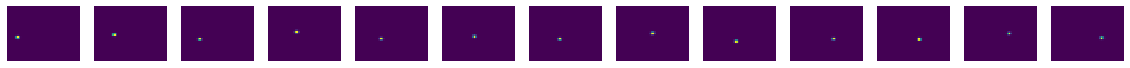

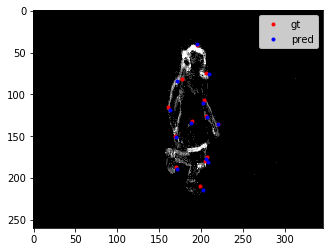

In [38]:
display(preds[2].numpy())
plot_2d(x[2].squeeze(), p_joints[2], gt_joints[2])